# IS 675 - Group Project

## DL Model - Drowsiness Detection

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Dividing the Dataset

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define base and target directories
base_dir = '/content/drive/MyDrive/IS675_data/test'  # Location of original images
target_base_dir = '/content/drive/MyDrive/IS675_data/DL Project data'  # Target directory for train, val, test
categories = ['DROWSY', 'NATURAL']  # Ensure the categories match folder names exactly

# Ensure train, val, and test directories with category subfolders exist
for split in ['train', 'val', 'test']:
    for category in categories:
        os.makedirs(os.path.join(target_base_dir, split, category), exist_ok=True)

# Move and split images into train, val, and test
for category in categories:
    original_path = os.path.join(base_dir, category)  # Path to the original images
    images = os.listdir(original_path)  # List of all images in the category folder

    # Split the data into train, val, and test
    train, temp = train_test_split(images, test_size=0.3, random_state=42)  # 70% train, 30% temp
    val, test = train_test_split(temp, test_size=0.5, random_state=42)      # Split temp into 15% val, 15% test

    # Move images to the train folder
    train_dir = os.path.join(target_base_dir, 'train', category)
    for img in train:
        shutil.move(os.path.join(original_path, img), os.path.join(train_dir, img))

    # Move images to the val folder
    val_dir = os.path.join(target_base_dir, 'val', category)
    for img in val:
        shutil.move(os.path.join(original_path, img), os.path.join(val_dir, img))

    # Move images to the test folder
    test_dir = os.path.join(target_base_dir, 'test', category)
    for img in test:
        shutil.move(os.path.join(original_path, img), os.path.join(test_dir, img))

print("Images successfully divided and moved!")


Images successfully divided and moved!


In [ ]:
# Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Subset
import seaborn as sns
from collections import Counter
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
from tabulate import tabulate

### Importing to Local Storage

In [ ]:
# Copy dataset to local storage
!cp -r "/content/drive/MyDrive/IS675_data/DL Project data" /content/

In [ ]:
# Dataset paths (use local paths)
base_path = '/content/DL Project data'
train_path = os.path.join(base_path, 'train')
val_path = os.path.join(base_path, 'val')
test_path = os.path.join(base_path, 'test')

### Pre-Processing

In [ ]:
# Image transformations
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:
# Load datasets
train_data_full = datasets.ImageFolder(train_path, transform=train_transform)
val_data = datasets.ImageFolder(val_path, transform=test_transform)
test_data = datasets.ImageFolder(test_path, transform=test_transform)

In [ ]:
# Use a smaller subset for quick testing (adjust as needed)
subset_size = 1000  # Adjust this as needed
train_indices = list(range(len(train_data_full)))
np.random.shuffle(train_indices)
train_subset = Subset(train_data_full, train_indices[:subset_size])

### Data Distribution

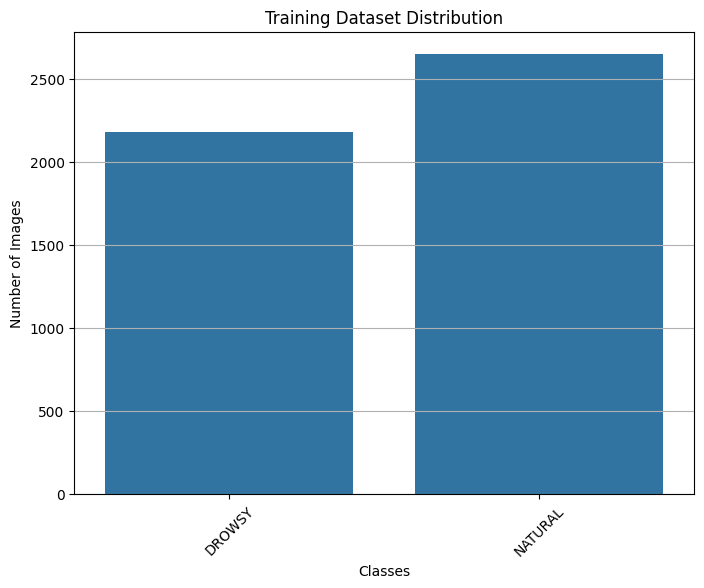

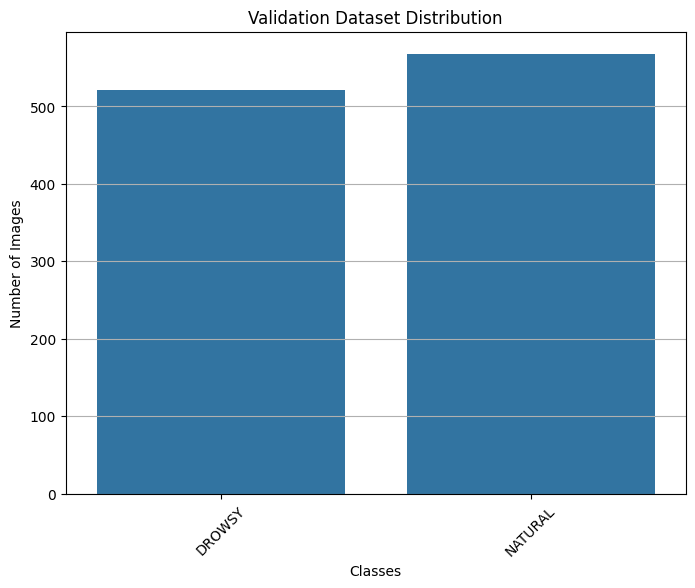

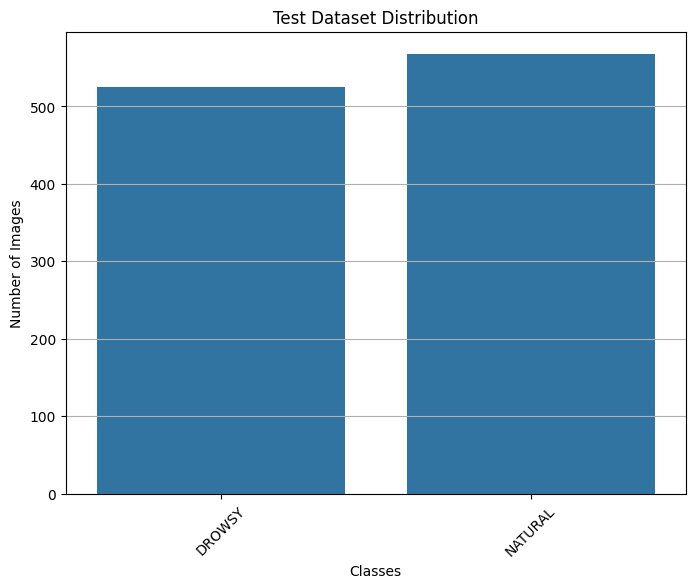

In [ ]:
# Function to visualize data distribution
def plot_data_distribution(dataset, title):
    class_counts = Counter([dataset.classes[label] for _, label in dataset.samples])
    plt.figure(figsize=(8, 6))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    plt.title(title)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

# Plot distributions for train, validation, and test datasets
plot_data_distribution(train_data_full, "Training Dataset Distribution")
plot_data_distribution(val_data, "Validation Dataset Distribution")
plot_data_distribution(test_data, "Test Dataset Distribution")

### Neural Networks

### CNN

In [ ]:
# Data loaders
def get_dataloaders(batch_size):
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return train_loader, val_loader, test_loader

# Transfer learning model with activation function parameter
class TransferLearningModel(nn.Module):
    def __init__(self, activation_func=nn.ReLU):
        super(TransferLearningModel, self).__init__()
        self.model = models.mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V1')
        for param in self.model.parameters():
            param.requires_grad = False
        # Modify the classifier to include an activation function
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.model.last_channel, 128),
            activation_func(),
            nn.Linear(128, 1)  # Output a single value for binary classification
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs=3, device='cuda'):
    model.to(device)
    history = {'Epoch': [], 'Train Loss': [], 'Val Loss': [], 'Val Accuracy': []}

    for epoch in range(1, n_epochs + 1):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
        history['Epoch'].append(epoch)
        history['Train Loss'].append(avg_train_loss)
        history['Val Loss'].append(avg_val_loss)
        history['Val Accuracy'].append(val_accuracy)
        print(f"Epoch {epoch}/{n_epochs}, Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    return history

# Evaluation function
def evaluate_model(model, loader, criterion, device='cuda'):
    model.eval()
    total_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            predicted = (torch.sigmoid(outputs) >= 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

### Hyper Parameters

In [ ]:
# Hyperparameter tuning
def hyperparameter_tuning(param_grid, device='cuda'):
    best_model, best_params, best_val_accuracy = None, None, 0.0
    results = []

    for params in ParameterGrid(param_grid):
        print(f"\nTesting params: {params}")
        train_loader, val_loader, test_loader = get_dataloaders(batch_size=params['batch_size'])
        model = TransferLearningModel(activation_func=params['activation_func'])
        criterion = nn.BCEWithLogitsLoss()
        optimizer = params['optimizer'](model.parameters(), lr=params['learning_rate'])
        history = train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs=params['epochs'], device=device)
        val_accuracy = history['Val Accuracy'][-1]

        # Evaluate on test set
        test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, device)
        print(f"Test Accuracy: {test_accuracy:.2f}%")

        results.append({'Batch Size': params['batch_size'],
                        'Learning Rate': params['learning_rate'],
                        'Optimizer': params['optimizer'].__name__,
                        'Activation': params['activation_func'].__name__,
                        'Epochs': params['epochs'],
                        'Val Accuracy (%)': val_accuracy,
                        'Test Accuracy (%)': test_accuracy})

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = model
            best_params = params

    # Create a DataFrame for results
    results_df = pd.DataFrame(results)

    # Print a formatted table
    print("\nHyperparameter Tuning Results Summary:")
    print(tabulate(results_df, headers='keys', tablefmt='fancy_grid', showindex=True))

    print(f"\nBest Parameters: {best_params}, Best Validation Accuracy: {best_val_accuracy:.2f}%")
    return best_model, best_params, results_df

# Define hyperparameter grid
param_grid = {
    'batch_size': [16, 32],  # Experiment with different batch sizes
    'learning_rate': [0.001, 0.0001],  # Try different learning rates
    'optimizer': [optim.Adam, optim.SGD],  # Try Adam and SGD
    'activation_func': [nn.ReLU, nn.Tanh],  # Include ReLU and Tanh
    'epochs': [20]  # Use shorter epochs for tuning
}

# Perform hyperparameter tuning
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model, best_params, results_df = hyperparameter_tuning(param_grid, device=device)

# Evaluate the best model on the test set
_, _, test_loader = get_dataloaders(batch_size=best_params['batch_size'])
criterion = nn.BCEWithLogitsLoss()
test_loss, test_accuracy = evaluate_model(best_model, test_loader, criterion, device)
print(f"\nBest Model Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Testing params: {'activation_func': <class 'torch.nn.modules.activation.ReLU'>, 'batch_size': 16, 'epochs': 20, 'learning_rate': 0.001, 'optimizer': <class 'torch.optim.adam.Adam'>}
Epoch 1/20, Train Loss: 0.5245, Val Loss: 0.4647, Val Accuracy: 77.96%
Epoch 2/20, Train Loss: 0.4055, Val Loss: 0.3963, Val Accuracy: 82.00%
Epoch 3/20, Train Loss: 0.4075, Val Loss: 0.3742, Val Accuracy: 83.20%
Epoch 4/20, Train Loss: 0.3521, Val Loss: 0.3933, Val Accuracy: 80.99%
Epoch 5/20, Train Loss: 0.3682, Val Loss: 0.3298, Val Accuracy: 85.22%
Epoch 6/20, Train Loss: 0.3554, Val Loss: 0.3345, Val Accuracy: 83.20%
Epoch 7/20, Train Loss: 0.3100, Val Loss: 0.3109, Val Accuracy: 85.22%
Epoch 8/20, Train Loss: 0.3229, Val Loss: 0.2837, Val Accuracy: 86.41%
Epoch 9/20, Train Loss: 0.2871, Val Loss: 0.3132, Val Accuracy: 85.03%
Epoch 10/20, Train Loss: 0.2942, Val Loss: 0.2686, Val Accuracy: 87.05%
Epoch 11/20, Train Loss: 0.2710, Val Loss: 0.2576, Val Accuracy: 87.97%
Epoch 12/20, Train Loss: 0.2560, V

### Results

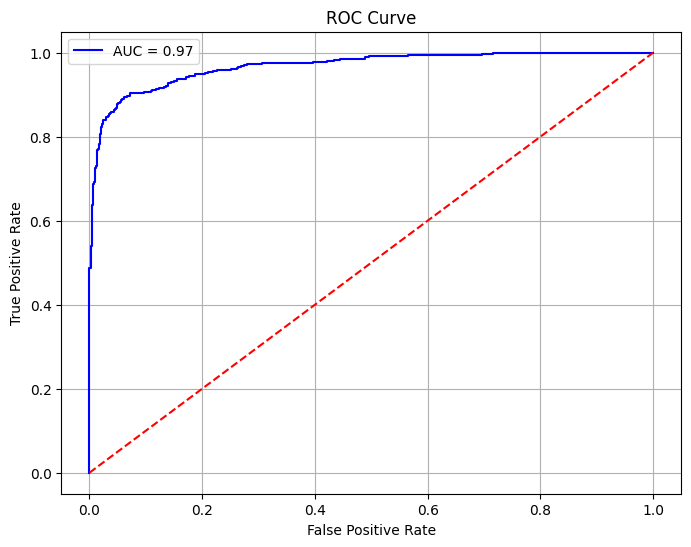

In [ ]:
# Visualizations: ROC Curve
def plot_roc_curve(model, loader, device='cuda'):
    model.eval()
    true_labels, predicted_probs = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs).cpu().numpy()
            predicted_probs.extend(probs.flatten())
            true_labels.extend(labels.cpu().numpy())
    fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='blue')
    plt.plot([0, 1], [0, 1], 'r--')  # Random guessing line
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the ROC curve for the best model
plot_roc_curve(best_model, test_loader, device)


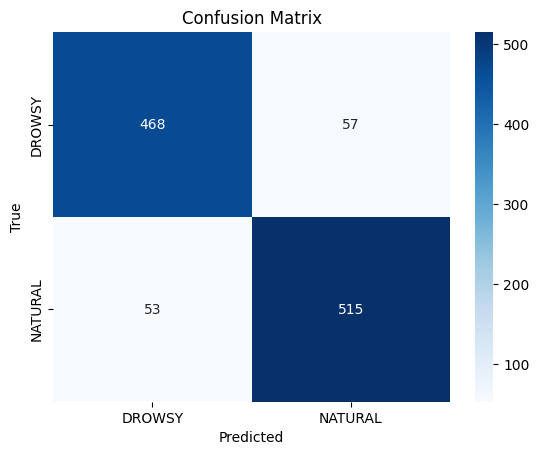

Classification Report:
              precision    recall  f1-score   support

      DROWSY       0.90      0.89      0.89       525
     NATURAL       0.90      0.91      0.90       568

    accuracy                           0.90      1093
   macro avg       0.90      0.90      0.90      1093
weighted avg       0.90      0.90      0.90      1093



In [ ]:
# Confusion Matrix and Classification Report
def evaluate_classification(model, loader, device='cuda'):
    model.eval()
    true_labels, predicted_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            predicted = (probs >= 0.5).int()
            predicted_labels.extend(predicted.cpu().numpy().flatten())
            true_labels.extend(labels.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=train_data_full.classes, yticklabels=train_data_full.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(true_labels, predicted_labels, target_names=train_data_full.classes))

# Evaluate the best model on the test set
evaluate_classification(best_model, test_loader, device)

### RNN

In [ ]:
# Data loaders
def get_dataloaders(batch_size):
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return train_loader, val_loader, test_loader

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_size=64 * 64 * 3, hidden_size=128, num_layers=2, num_classes=1):
        super(RNNModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1, self.input_size)  # Reshape to (batch_size, sequence_length, input_size)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        out, _ = self.rnn(x, (h0, c0))
        out = out[:, -1, :]  # Take the output of the last time step
        out = self.fc(out)
        return out

In [ ]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs=3, device='cuda'):
    model.to(device)
    history = {'Epoch': [], 'Train Loss': [], 'Val Loss': [], 'Val Accuracy': []}

    for epoch in range(1, n_epochs + 1):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
        history['Epoch'].append(epoch)
        history['Train Loss'].append(avg_train_loss)
        history['Val Loss'].append(avg_val_loss)
        history['Val Accuracy'].append(val_accuracy)
        print(f"Epoch {epoch}/{n_epochs}, Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    return history

# Evaluation function
def evaluate_model(model, loader, criterion, device='cuda'):
    model.eval()
    total_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            predicted = (torch.sigmoid(outputs) >= 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

### Hyper Parameters

In [ ]:
# Hyperparameter tuning for different model types
def hyperparameter_tuning(param_grid, model_type, device='cuda'):
    best_model, best_params, best_val_accuracy = None, None, 0.0
    results = []

    for params in ParameterGrid(param_grid):
        print(f"\nTesting params: {params}")
        train_loader, val_loader, test_loader = get_dataloaders(batch_size=params['batch_size'])

        # Initialize the appropriate model
        if model_type == 'cnn':
            model = TransferLearningModel(activation_func=nn.ReLU)  # Use CNN model
        elif model_type == 'rnn':
            model = RNNModel(input_size=64 * 64 * 3, hidden_size=128, num_layers=2, num_classes=1)  # Use RNN model
        else:
            raise ValueError(f"Unsupported model_type: {model_type}")

        criterion = nn.BCEWithLogitsLoss()
        optimizer = params['optimizer'](model.parameters(), lr=params['learning_rate'])
        history = train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs=params['epochs'], device=device)
        val_accuracy = history['Val Accuracy'][-1]

        # Evaluate on test set
        test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, device)
        print(f"Test Accuracy: {test_accuracy:.2f}%")

        results.append({'Batch Size': params['batch_size'],
                        'Learning Rate': params['learning_rate'],
                        'Optimizer': params['optimizer'].__name__,
                        'Epochs': params['epochs'],
                        'Val Accuracy (%)': val_accuracy,
                        'Test Accuracy (%)': test_accuracy})

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = model
            best_params = params

    # Create a DataFrame for results
    results_df = pd.DataFrame(results)

    # Print a formatted table
    print("\nHyperparameter Tuning Results Summary:")
    print(tabulate(results_df, headers='keys', tablefmt='fancy_grid', showindex=True))

    print(f"\nBest Parameters: {best_params}, Best Validation Accuracy: {best_val_accuracy:.2f}%")
    return best_model, best_params, results_df


In [ ]:
# Adjust the hyperparameter grid for the RNN
rnn_param_grid = {
    'batch_size': [16, 32],
    'learning_rate': [0.001, 0.0001],
    'optimizer': [optim.Adam, optim.SGD],
    'epochs': [20]
}

# Perform hyperparameter tuning for RNN
best_rnn_model, best_rnn_params, rnn_results_df = hyperparameter_tuning(rnn_param_grid, model_type='rnn', device=device)

# Evaluate the best RNN model
_, _, test_loader = get_dataloaders(batch_size=best_rnn_params['batch_size'])
criterion = nn.BCEWithLogitsLoss()
test_loss, test_accuracy = evaluate_model(best_rnn_model, test_loader, criterion, device)
print(f"\nBest RNN Model Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")



Testing params: {'batch_size': 16, 'epochs': 20, 'learning_rate': 0.001, 'optimizer': <class 'torch.optim.adam.Adam'>}
Epoch 1/20, Train Loss: 0.4516, Val Loss: 0.4088, Val Accuracy: 80.81%
Epoch 2/20, Train Loss: 0.3146, Val Loss: 0.3452, Val Accuracy: 83.38%
Epoch 3/20, Train Loss: 0.2931, Val Loss: 0.3537, Val Accuracy: 84.30%
Epoch 4/20, Train Loss: 0.2661, Val Loss: 0.3712, Val Accuracy: 84.85%
Epoch 5/20, Train Loss: 0.2539, Val Loss: 0.3146, Val Accuracy: 86.50%
Epoch 6/20, Train Loss: 0.2415, Val Loss: 0.3429, Val Accuracy: 85.95%
Epoch 7/20, Train Loss: 0.2230, Val Loss: 0.3233, Val Accuracy: 86.96%
Epoch 8/20, Train Loss: 0.2006, Val Loss: 0.3167, Val Accuracy: 86.32%
Epoch 9/20, Train Loss: 0.2053, Val Loss: 0.3852, Val Accuracy: 85.12%
Epoch 10/20, Train Loss: 0.2009, Val Loss: 0.3734, Val Accuracy: 85.12%
Epoch 11/20, Train Loss: 0.2002, Val Loss: 0.3352, Val Accuracy: 86.87%
Epoch 12/20, Train Loss: 0.1947, Val Loss: 0.3364, Val Accuracy: 85.12%
Epoch 13/20, Train Loss: 

### Results

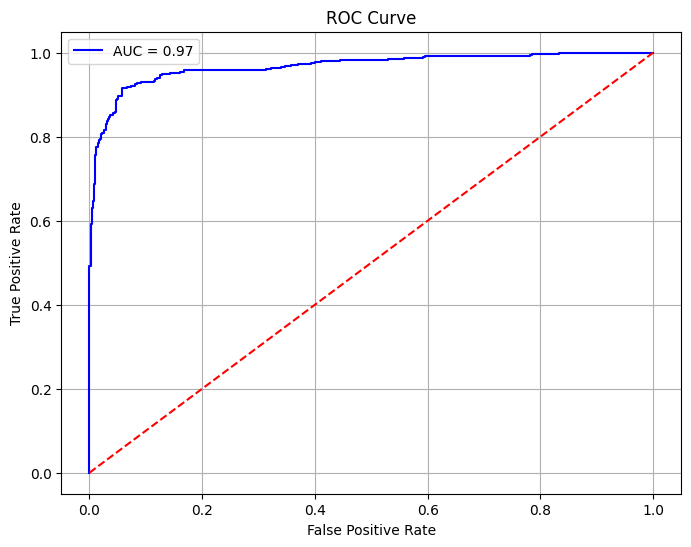

In [ ]:
# Visualizations: ROC Curve
def plot_roc_curve(model, loader, device='cuda'):
    model.eval()
    true_labels, predicted_probs = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs).cpu().numpy()
            predicted_probs.extend(probs.flatten())
            true_labels.extend(labels.cpu().numpy())
    fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='blue')
    plt.plot([0, 1], [0, 1], 'r--')  # Random guessing line
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the ROC curve for the best model
plot_roc_curve(best_rnn_model, test_loader, device)

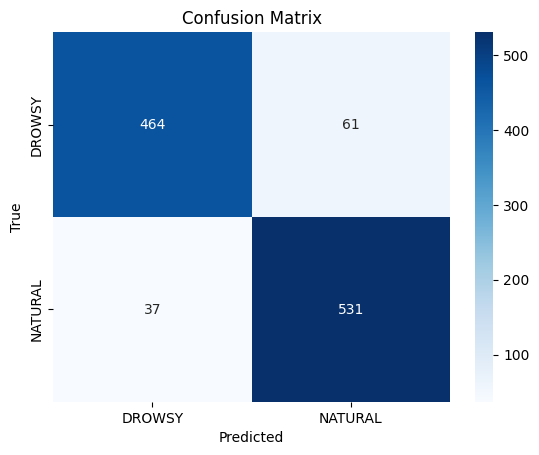

Classification Report:
              precision    recall  f1-score   support

      DROWSY       0.93      0.88      0.90       525
     NATURAL       0.90      0.93      0.92       568

    accuracy                           0.91      1093
   macro avg       0.91      0.91      0.91      1093
weighted avg       0.91      0.91      0.91      1093



In [ ]:
# Confusion Matrix and Classification Report
def evaluate_classification(model, loader, device='cuda'):
    model.eval()
    true_labels, predicted_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            predicted = (probs >= 0.5).int()
            predicted_labels.extend(predicted.cpu().numpy().flatten())
            true_labels.extend(labels.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=train_data_full.classes, yticklabels=train_data_full.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(true_labels, predicted_labels, target_names=train_data_full.classes))

# Evaluate the best model on the test set
evaluate_classification(best_rnn_model, test_loader, device)


### Comparisons

Model Performance Comparison:
╒═════════════════╤════════════╤═════════════╤══════════╕
│                 │   Accuracy │   Precision │   Recall │
╞═════════════════╪════════════╪═════════════╪══════════╡
│ CNN (MobileNet) │       0.9  │        0.9  │     0.9  │
├─────────────────┼────────────┼─────────────┼──────────┤
│ RNN             │       0.91 │        0.91 │     0.91 │
╘═════════════════╧════════════╧═════════════╧══════════╛


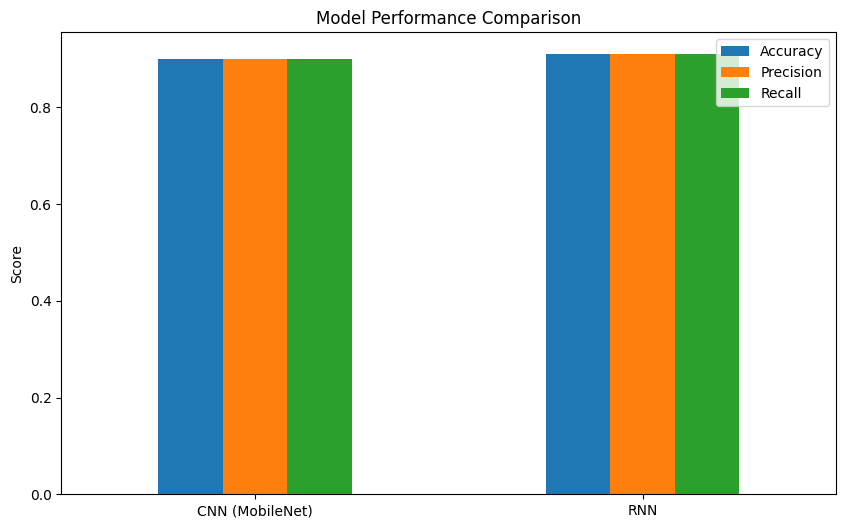

In [ ]:
def compare_models(cnn_metrics, rnn_metrics, metric_names):
    """
    Compare performance metrics of CNN and RNN models.

    Args:
    cnn_metrics: List of CNN metrics [accuracy, precision, recall].
    rnn_metrics: List of RNN metrics [accuracy, precision, recall].
    metric_names: List of metric names corresponding to the values in cnn_metrics and rnn_metrics.
    """
    metrics_df = pd.DataFrame([cnn_metrics, rnn_metrics],
                              index=['CNN (MobileNet)', 'RNN'],
                              columns=metric_names)

    print("Model Performance Comparison:")
    print(tabulate(metrics_df, headers='keys', tablefmt='fancy_grid'))

    # Plot the metrics
    metrics_df.plot(kind='bar', figsize=(10, 6))
    plt.title("Model Performance Comparison")
    plt.ylabel("Score")
    plt.xticks(rotation=0)
    plt.legend(loc='upper right')
    plt.show()

# Metrics extracted from the classification reports
cnn_test_accuracy = 0.90
cnn_precision = 0.90  # Weighted average precision
cnn_recall = 0.90     # Weighted average recall

rnn_test_accuracy = 0.91
rnn_precision = 0.91  # Weighted average precision
rnn_recall = 0.91     # Weighted average recall

# Metric names
metric_names = ['Accuracy', 'Precision', 'Recall']

# Call the function with updated values
compare_models([cnn_test_accuracy, cnn_precision, cnn_recall],
               [rnn_test_accuracy, rnn_precision, rnn_recall],
               metric_names)

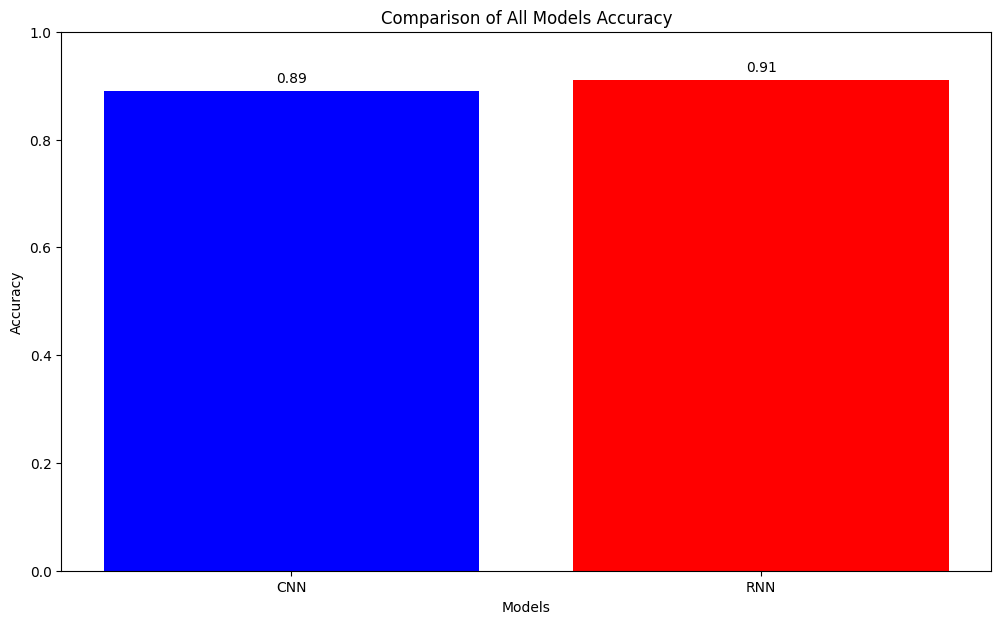

In [ ]:
import matplotlib.pyplot as plt

accuracies = {
    'CNN': 0.89,
    'RNN': 0.91,
}

models = list(accuracies.keys())
accuracy_values = [accuracies[model] for model in models]

plt.figure(figsize=(12, 7))
bars = plt.bar(models, accuracy_values, color=['blue', 'red'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of All Models Accuracy')
plt.ylim([0, 1])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

plt.show()

## Project Highlights
Dataset Handling:
Efficiently split the dataset into train, validation, and test sets with balanced class distributions.
Applied appropriate data augmentation techniques for training robustness.


Model Choices:

CNN with Transfer Learning:<br>
* MobileNetV2 architecture was fine-tuned with modified layers.<br>
* Achieved high test accuracy (~90%+ for optimal configurations).

RNN:
* LSTM-based model performed well for sequential data analysis.
* Best configuration achieved ~91% accuracy.

Hyperparameter Tuning:
* Parameter grid search explored batch sizes, learning rates, optimizers, and activation functions.
* Best CNN configuration: ReLU, Adam, 16 batch size, 0.001 learning rate, 20 epochs.
* Best RNN configuration: Adam, 16 batch size, 0.0001 learning rate, 20 epochs.

Performance Evaluation:
* ROC Curve and AUC provided insights into model discrimination power.
* Confusion Matrix and Classification Report detailed precision, recall, and F1-scores.

In [ ]:
!jupyter nbconvert --to html "/content/drive/MyDrive/DL model.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/DL model.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 9 image(s).
[NbConvertApp] Writing 716854 bytes to /content/drive/MyDrive/DL model.html
